In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import torch.nn.functional as F
torch.set_printoptions(linewidth=120)

import pickle as serializer


In [2]:
with open('dataset.txt', 'rb') as f:
    dataset = serializer.load(f)
    

DataDict = {"image":[],"steer":[],"throttle":[],"direction":[],"command":[]}
keys = dataset.keys()
for key in keys:
    for label in dataset[key]:
        #DataDict["image"].append(label[0])
        if label[3] == 'left':
            label[3] = 1
        if label[3] == 'right':
            label[3] = 3
        if label[3] == 'forward':
            label[3] = 2
        if key == 'left':
            key = 1
        if key == 'right':
            key = 3
        if key == 'forward':
            key = 2
        if key == 'continue':
            key = 0
        label.append(key)
        DataDict["image"].append(label[0])
        DataDict["steer"].append(label[1])
        DataDict["throttle"].append(label[2])
        DataDict["direction"].append(label[3])
        DataDict["command"].append(label[4])

with open('DataDict.txt', 'wb') as f:
    serializer.dump(DataDict, f)

In [3]:
img_name = DataDict["image"][1]
print('Image name: {}'.format(img_name))

Image name: 2018_11_30_14_48_17/image_forward1.png


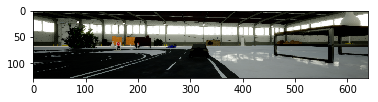

5


In [4]:
def show_image(image):
    plt.imshow(image)

plt.figure()
show_image(io.imread(os.path.join('Bilder/',img_name)))
plt.show()
print(len(DataDict))

In [5]:
class AISProject(Dataset):
    """ AIS Project dataset."""
    def __init__(self, dictionary, root_dir, transform = None):

        self.dictionary = pd.DataFrame.from_dict(dictionary)
        self.root_dir = root_dir
        self.transform = transform
        print(len(dictionary))
        
    def __len__(self):
        return len(self.dictionary)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,self.dictionary.iloc[idx,0])
        image = io.imread(img_name)
        labels = self.dictionary.iloc[idx,1:].as_matrix()
        labels = labels.astype('float').reshape(-1,4)
        sample = {'image':image, 'labels': labels }
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample


5
0 (128, 640, 3) (1, 4)
1 (128, 640, 3) (1, 4)
2 (128, 640, 3) (1, 4)
3 (128, 640, 3) (1, 4)


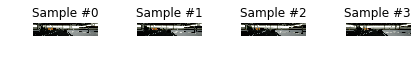

In [6]:
driving_dataset = AISProject(dictionary = DataDict, root_dir = 'Bilder/')

fig = plt.figure()

for i in range(len(driving_dataset)):
    sample = driving_dataset[i]
    print(i, sample['image'].shape, sample['labels'].shape)
    
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_image(sample['image'])
    if i == 3:
        plt.show()
        break
        

In [7]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']
        image = image.transpose((2,0,1))
        return {'image': torch.from_numpy(image), 
                'labels': torch.from_numpy(labels)}

5
0 tensor([[[ 17,  16,  15,  ...,  27,  27,  25],
         [ 21,  22,  23,  ...,  17,  18,  19],
         [128, 129, 129,  ...,  17,  17,  13],
         ...,
         [  0,   0,   0,  ..., 105, 104, 104],
         [  0,   0,   0,  ..., 104, 105, 104],
         [  0,   0,   1,  ..., 104, 104, 104]],

        [[ 20,  20,  19,  ...,  28,  27,  26],
         [ 24,  25,  26,  ...,  17,  17,  18],
         [131, 131, 131,  ...,  14,  14,   9],
         ...,
         [  0,   1,   0,  ..., 111, 110, 110],
         [  0,   0,   0,  ..., 110, 111, 110],
         [  0,   0,   1,  ..., 110, 110, 109]],

        [[ 10,   9,   8,  ...,  17,  17,  16],
         [ 14,  15,  16,  ...,   6,   7,   8],
         [123, 123, 123,  ...,   8,   9,   3],
         ...,
         [  0,   0,   0,  ..., 107, 106, 107],
         [  0,   0,   0,  ..., 107, 108, 107],
         [  0,   0,   1,  ..., 106, 106, 106]]], dtype=torch.uint8) torch.Size([1, 4])
1 tensor([[[ 15,  14,  13,  ...,  25,  24,  25],
         [ 20, 

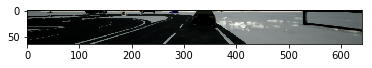

In [42]:
transformed_dataset = AISProject(dictionary = DataDict, root_dir='Bilder/', 
                                transform = transforms.Compose([RandomCrop(), ToTensor()]))
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'], sample['labels'].size())
    
    if i == 3:
        break


In [ ]:
dataloader = DataLoader(transformed_dataset, batch_size=10, 
                        shuffle=False, num_workers=0)
dataloader2 = DataLoader(transformed_dataset, batch_size=1, 
                        shuffle=False, num_workers=0)
def show_labels_batch(sample_batched):
    """Show image with labels for a batch of samples."""
    images_batch, labels_batch = \
        sample_batched['image'], sample_batched['labels']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1,2,0)))



for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), 
         sample_batched['labels'].size())

    if i_batch == 1:
        plt.figure(figsize=(40,40))
        show_labels_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

        

In [ ]:
device = torch.device("cpu")
# Definition of the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)    # FYI: In the lecture I forgot to add the padding, thats why the feature size calculation was wrong
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv8_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(23552, 50)
        self.fc2 = nn.Linear(50, 4)

    def forward(self, x):
        #x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(self.conv1(x))
        #x = F.relu(self.conv2(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),3)
        #x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(self.conv3(x))
        #x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = F.max_pool2d(F.relu(self.conv4(x)),3)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        #x = F.relu(self.conv8(x))
        x = F.max_pool2d(F.relu(self.conv8_drop(self.conv8(x)), 2),3)
        x = x.view(-1, 23552)   # Flatten data for fully connected layer. Input size is 28*28, we have 2 pooling layers so we pool the spatial size down to 7*7. With 20 feature maps as the output of the previous conv we have in total 7x7x20 = 980 features.
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

# We create the network, shift it on the GPU and define a optimizer on its parameters
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [ ]:
# This function trains the neural network for one epoch
def train(epoch):
    #TestTestTEst
    if os.path.isfile("Netz.pt"):
        model = torch.load("Netz.pt")
    else:
        model = Net().to(device)
    model.train()
    for batch_idx, sample in enumerate(dataloader):
        # Move the input and target data on the GPU
        sample['image'] = sample['image'].type('torch.FloatTensor')
        sample['labels'] = sample['labels'].type('torch.FloatTensor')
        
        data, target = sample['image'].to(device), sample['labels'].to(device)  # .cuda() works too instead of .to(device)

        # Zero out gradients from previous step
        optimizer.zero_grad()
        Loss = nn.L1Loss()
        output = model(data)
        target = target.reshape(1,4)
        print(output.shape)
        print(target.shape)
        print(output)
        print(target)
        
        loss = nn.L1Loss(output[0][0], target[0][0])
        # Loss.backward()
        # Adjusting the parameters according to the loss function
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), len(dataloader.dataset)))
        torch.save(model, "Netz.pt")


In [ ]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader2:
            data, target = data.to(device), target.to(device)
            output = model(data)
            print(output)
            test_loss += nn.L1Loss(output[0][0], target[0][0], size_average=False) # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

            if not pred.eq(target.view_as(pred)):   ## If you just want so see the failing examples
                cv_mat = data.cpu().data.squeeze().numpy()
                cv_mat = cv2.resize(cv_mat, (400, 400))
                cv2.imshow("test image", cv_mat)
                print("Target label is : %d" % target.cpu().item())
                print("Predicted label is : %d" % (pred.cpu().data.item()))
                cv2.waitKey()

            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dataloader2.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(dataloader2.dataset),
        100. * correct / len(dataloader2.dataset)))

num_train_epochs = 1
for epoch in range(1, num_train_epochs + 1):
    train(epoch)

test()

In [41]:
class RandomCrop(object):
    """Class to crop our data. (Modified RandomCrop, so that the crop isn't random anymore)"""
    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']

        h, w = image.shape[:2]
        #new_h, new_w = output_size
        new_h = 64
        image = image[new_h:h, 0:w]
        #show_image to test whether the pictures are cropped as we wish
        show_image(image)
        return {'image': image, 'labels': labels}